In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
data = pd.read_csv("US_Accidents_March23.csv")
missing = data.isnull().sum()
#print(missing)
print("Number of Entries before drop = ", len(data))

# dropping columns with NaN 
data_dropped = data.dropna()
print("Number of Entries after drop = ", len(data_dropped))

#print(data_dropped['End_Time'])

# converting columns to datetime 
data_dropped['Start_Time'] = pd.to_datetime(data_dropped['Start_Time'], errors='coerce')
data_dropped['End_Time'] = pd.to_datetime(data_dropped['End_Time'], errors='coerce')

#print(data_dropped['End_Time'])

# dropping unneeded column (can drop more if decided)
data_cleaned = data_dropped.drop(['Source'], axis=1)

data_cleaned.to_csv('preprocessed_data.csv', index=False)

In [2]:
data = pd.read_csv("preprocessed_data.csv")
data.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City',
       'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [3]:
# Print old unique values
#print(data['Weather_Condition'].unique())
print(len(data['Weather_Condition'].unique()))

condition_map = {
    'Drizzle / Windy' : 'Drizzle',
    'Heavy Drizzle' : ' Drizzle',
    'Heavy Rain / Windy' : 'Heavy Rain',
    'Heavy Rain Shower' : 'Heavy Rain',
    'Heavy Rain Shower / Windy' : 'Heavy Rain',
    'Heavy Rain Showers' : 'Heavy Rain',
    'Heavy Snow / Windy' : 'Heavy Snow',
    'Heavy Snow with Thunder' : 'Heavy Snow',
    'Heavy T-Storm / Windy': 'Thunderstorms',
    'Heavy T-Storm': 'Thunderstorms',
    'Heavy Thunderstorms and Rain': 'Thunderstorms',
    'Heavy Thunderstorms and Rain' : 'Thunderstorms',
    'Heavy Thunderstorms and Snow' : 'Thunderstorms',
    'Heavy Thunderstorms with Small Hail' : 'Thunderstorms',
    'Light Blowing Snow': 'Light Snow',
    'Light Drizzle / Windy' :' Light Drizzle',
    'Light Rain / Windy' : 'Light Rain',
    'Light Rain Shower' : 'Light Rain',
    'Light Rain Shower / Windy' : 'Light Rain',
    'Light Rain Showers' : 'Light Rain',
    'Light Rain with Thunder' : 'Light Rain',
    'Light Sleet / Windy' :'Light Sleet',
    'Light Snow / Windy' : 'Light Snow',
    'Light Snow and Sleet' : 'Light Snow',
    'Light Snow Grains' : 'Light Snow',
    'Light Snow Shower' : 'Light Snow',
    'Light Thunderstorms and Rain' : 'Light Thunderstorms',
    'Light Thunderstorms and Snow' : 'Light Thunderstorms',
    'Rain / Windy' : 'Rain',
    'Rain Shower' : 'Rain', 
    'Rain Shower / Windy' : 'Rain',
    'Rain Showers' : 'Rain',
    'Snow / Windy' : 'Snow',
    'Snow and Sleet' : 'Snow',
    'Thunder' : 'Thunderstorms',
    'T-Storm' : ' Thunderstorms',
    'T-Storm / Windy' : ' Thunderstorms',
    'Thunder / Windy' : 'Thunderstorms',
    'Thunder in the Vicinity' : 'Thunderstorms',
    'Thunderstorms and Rain' : 'Thunderstorms',
    'Thunderstorms and Snow' : 'Thunderstorms',
    'Wintry Mix / Windy' : 'Wintry Mix',
    'Scattered Clouds' : 'Partly Cloudy',
    'Overcast' : 'Mostly Cloudy',
    'Light Drizzle': 'Light Rain',
    'Cloudy / Windy' : 'Windy',
    'Fair / Windy' : 'Windy',
    'Mostly Cloudy / Windy' : 'Windy',
    'Partly Cloudy / Windy' : 'Windy',
    'Fair' : 'Clear',

}

# Replace redundant conditions
data2 = data
data2['Weather_Condition'].replace(condition_map, inplace=True)

# Print new unique values
#print(data2['Weather_Condition'].unique())
print(len(data2['Weather_Condition'].unique()))

data2.to_csv('fixed_conditions.csv', index=False)

122
84


In [2]:
data = pd.read_csv("fixed_conditions.csv")

In [3]:
data['Start_Time'] = pd.to_datetime(data["Start_Time"], errors = 'coerce').astype('int64')
data['End_Time'] = pd.to_datetime(data["End_Time"], errors = 'coerce').astype('int64')
data['Duration'] = (data.End_Time - data.Start_Time).div(10**9)
data = data.dropna()
#turns the "Start_Time" feature into a road-trip time length feature

In [4]:
# Feature selection (choose relevant columns)
selected_features = ["Start_Lat", "Start_Lng","End_Lat", "End_Lng", "Start_Time", "End_Time", "Duration", "Weather_Condition", #
                     "Timezone", "Turning_Loop", "No_Exit", "Crossing", "Junction", "Stop", "Traffic_Signal", "Severity"]

df = pd.get_dummies(data[selected_features], columns = [ "Timezone", "Weather_Condition"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Severity"]),df["Severity"], test_size=0.2, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model with a 20% test split: {accuracy:.2f}")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy of the logistic regression model with a 20% test split: 0.94


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
The figure layout has changed to tight


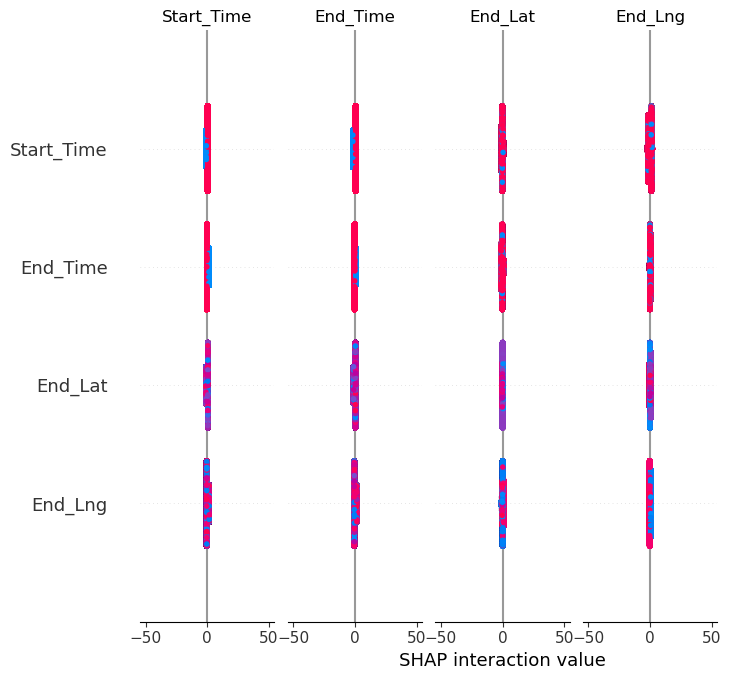

In [8]:
# Calculate SHAP values
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Visualize feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=df.drop(columns=["Severity"]).columns)

In [9]:
df.drop(columns=["Severity"]).columns

Index(['End_Lat', 'End_Lng', 'Start_Time', 'End_Time', 'Duration',
       'Turning_Loop', 'No_Exit', 'Crossing', 'Junction', 'Stop',
       'Traffic_Signal', 'Timezone_US/Central', 'Timezone_US/Eastern',
       'Timezone_US/Mountain', 'Timezone_US/Pacific',
       'Weather_Condition_ Drizzle', 'Weather_Condition_ Light Drizzle',
       'Weather_Condition_ Thunderstorms', 'Weather_Condition_Blowing Dust',
       'Weather_Condition_Blowing Dust / Windy',
       'Weather_Condition_Blowing Sand', 'Weather_Condition_Blowing Snow',
       'Weather_Condition_Blowing Snow / Windy',
       'Weather_Condition_Blowing Snow Nearby', 'Weather_Condition_Clear',
       'Weather_Condition_Cloudy', 'Weather_Condition_Drifting Snow',
       'Weather_Condition_Drifting Snow / Windy', 'Weather_Condition_Drizzle',
       'Weather_Condition_Drizzle and Fog', 'Weather_Condition_Fog',
       'Weather_Condition_Fog / Windy', 'Weather_Condition_Freezing Drizzle',
       'Weather_Condition_Freezing Rain',
      

In [6]:
import pickle
with open('Regression_Model.pkl', 'wb') as file:
    pickle.dump(model, file)